# Computing four elements of C at a time

* We will compute 4 elements of matrix C at a time. i.e. 1x4 block
* We will use register to improve performance

In [10]:
# set environment 
%env ROOT_PATH=../..

env: ROOT_PATH=../..


In [14]:
# load libs
from load_data import load_data

# path
root_path='../..'

## Optimization 1

Change from MMult0.c to MMult1.c, we write AddDot function for dot-product. We will not gain performance by this rewriting

```
/* Create macros so that the matrices are stored in column-major order */

#define A(i,j) a[ (j)*lda + (i) ]
#define B(i,j) b[ (j)*ldb + (i) ]
#define C(i,j) c[ (j)*ldc + (i) ]

/* Routine for computing C = A * B + C */

void AddDot( int, double *, int, double *, double * );

void MY_MMult( int m, int n, int k, double *a, int lda, 
                                    double *b, int ldb,
                                    double *c, int ldc )
{
  int i, j;

  for ( j=0; j<n; j+=1 ){        /* Loop over the columns of C */
    for ( i=0; i<m; i+=1 ){        /* Loop over the rows of C */
      /* Update the C( i,j ) with the inner product of the ith row of A
	 and the jth column of B */

      AddDot( k, &A( i,0 ), lda, &B( 0,j ), &C( i,j ) );
    }
  }
}


/* Create macro to let X( i ) equal the ith element of x */

#define X(i) x[ (i)*incx ]

void AddDot( int k, double *x, int incx,  double *y, double *gamma )
{
  /* compute gamma := x' * y + gamma with vectors x and y of length n.

     Here x starts at location x with increment (stride) incx and y starts at location y and has (implicit) stride of 1.
  */
 
  int p;

  for ( p=0; p<k; p++ ){
    *gamma += X( p ) * y[ p ];     
  }
}
```

In [15]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult1 -DOUT=../data/MMult1 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

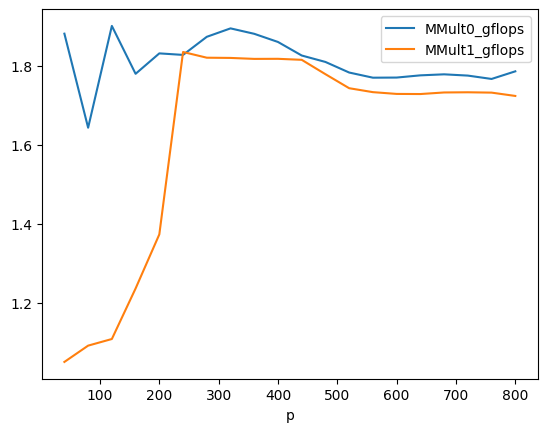

In [16]:
# import result and plot
data = load_data([f'{root_path}/data/MMult0.csv', f'{root_path}/data/MMult1.csv'])
data.plot()

## Optimization 2

We will do 4 elements of Matrix C update. But we call AddDot 4 times in MY_MMult. For each AddDot, there will be a for-loop. 
So, we in fact have 4 for-loops for 4 AddDot. Then we can not gain performance with SIMD.

part of code in MMult2.c
```
void MY_MMult( int m, int n, int k, double *a, int lda, 
                                    double *b, int ldb,
                                    double *c, int ldc )
{
  int i, j;

  for ( j=0; j<n; j+=4 ){        /* Loop over the columns of C, unrolled by 4 */
    for ( i=0; i<m; i+=1 ){        /* Loop over the rows of C */
      /* Update the C( i,j ) with the inner product of the ith row of A
	 and the jth column of B */

      AddDot( k, &A( i,0 ), lda, &B( 0,j ), &C( i,j ) );

      /* Update the C( i,j+1 ) with the inner product of the ith row of A
	 and the (j+1)th column of B */

      AddDot( k, &A( i,0 ), lda, &B( 0,j+1 ), &C( i,j+1 ) );

      /* Update the C( i,j+2 ) with the inner product of the ith row of A
	 and the (j+2)th column of B */

      AddDot( k, &A( i,0 ), lda, &B( 0,j+2 ), &C( i,j+2 ) );

      /* Update the C( i,j+3 ) with the inner product of the ith row of A
	 and the (j+1)th column of B */

      AddDot( k, &A( i,0 ), lda, &B( 0,j+3 ), &C( i,j+3 ) );
    }
  }
}

```

In [17]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult2 -DOUT=../data/MMult2 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

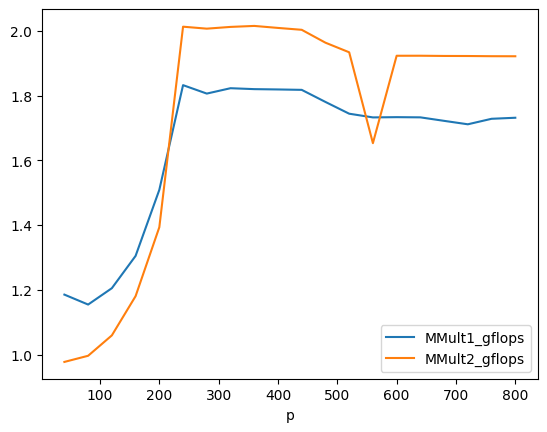

In [5]:
# import result and plot
data = load_data([f'{root_path}/data/MMult1.csv', f'{root_path}/data/MMult2.csv'])
data.plot()

### Result

No performance gain by just calling 4 times AddDot in the loop

## Optimization 3. AddDot 1x4

Just setup a new function AddDot1x4, which call 4 times AddDot. Still, Each AddDot will have a for-looping, no blocking.
No performance gain expected

```
void AddDot1x4( int k, double *a, int lda,  double *b, int ldb, double *c, int ldc )
{
  /* So, this routine computes four elements of C: 

           C( 0, 0 ), C( 0, 1 ), C( 0, 2 ), C( 0, 3 ).  

     Notice that this routine is called with c = C( i, j ) in the
     previous routine, so these are actually the elements 

           C( i, j ), C( i, j+1 ), C( i, j+2 ), C( i, j+3 ) 
	  
     in the original matrix C */ 

  AddDot( k, &A( 0, 0 ), lda, &B( 0, 0 ), &C( 0, 0 ) );
  AddDot( k, &A( 0, 0 ), lda, &B( 0, 1 ), &C( 0, 1 ) );
  AddDot( k, &A( 0, 0 ), lda, &B( 0, 2 ), &C( 0, 2 ) );
  AddDot( k, &A( 0, 0 ), lda, &B( 0, 3 ), &C( 0, 3 ) );
}
```

In [6]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_3 -DOUT=../data/MMult_1x4_3 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

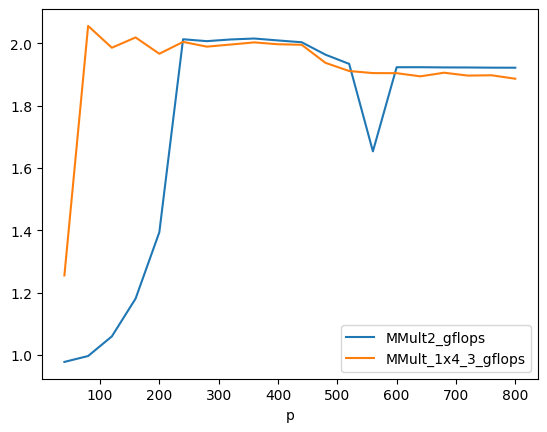

In [7]:
# import result and plot
data = load_data([f'{root_path}/data/MMult2.csv', f'{root_path}/data/MMult_1x4_3.csv'])
data.plot()

## Optimization 4 and 5

Now we inline the four separate inner products and fuse the loops into one, thereby computing the four inner products simultaneously in one loop.

* First, we inline the inner products into AddDot1x4 to get MMult_1x4_4.c. Only doing inline will not give performance gain.
* Second, we fuse the 4 loops for inner products into one. This will give performance gain due to SIMD

Part of code of MMult_1x4_4.c to inline code of AddDot into AddDot1x4
```
void AddDot1x4( int k, double *a, int lda,  double *b, int ldb, double *c, int ldc )
{
  /* So, this routine computes four elements of C: 

           C( 0, 0 ), C( 0, 1 ), C( 0, 2 ), C( 0, 3 ).  

     Notice that this routine is called with c = C( i, j ) in the
     previous routine, so these are actually the elements 

           C( i, j ), C( i, j+1 ), C( i, j+2 ), C( i, j+3 ) 
	  
     in the original matrix C.

     In this version, we "inline" AddDot */ 

  int p;

  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 0 ), &C( 0, 0 ) );
  for ( p=0; p<k; p++ ){
    C( 0, 0 ) += A( 0, p ) * B( p, 0 );     
  }

  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 1 ), &C( 0, 1 ) );
  for ( p=0; p<k; p++ ){
    C( 0, 1 ) += A( 0, p ) * B( p, 1 );     
  }

  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 2 ), &C( 0, 2 ) );
  for ( p=0; p<k; p++ ){
    C( 0, 2 ) += A( 0, p ) * B( p, 2 );     
  }

  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 3 ), &C( 0, 3 ) );
  for ( p=0; p<k; p++ ){
    C( 0, 3 ) += A( 0, p ) * B( p, 3 );     
  }
}
```

Part of code of MMult_1x4_5.c to fuse 4 inner product into 1 for-loop.
```
void AddDot1x4( int k, double *a, int lda,  double *b, int ldb, double *c, int ldc )
{
  /* So, this routine computes four elements of C: 

           C( 0, 0 ), C( 0, 1 ), C( 0, 2 ), C( 0, 3 ).  

     Notice that this routine is called with c = C( i, j ) in the
     previous routine, so these are actually the elements 

           C( i, j ), C( i, j+1 ), C( i, j+2 ), C( i, j+3 ) 
	  
     in the original matrix C.

     In this version, we merge the four loops, computing four inner
     products simultaneously. */

  int p;

  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 0 ), &C( 0, 0 ) );
  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 1 ), &C( 0, 1 ) );
  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 2 ), &C( 0, 2 ) );
  //  AddDot( k, &A( 0, 0 ), lda, &B( 0, 3 ), &C( 0, 3 ) );
  for ( p=0; p<k; p++ ){
    C( 0, 0 ) += A( 0, p ) * B( p, 0 );     
    C( 0, 1 ) += A( 0, p ) * B( p, 1 );     
    C( 0, 2 ) += A( 0, p ) * B( p, 2 );     
    C( 0, 3 ) += A( 0, p ) * B( p, 3 );     
  }
}
```







In [8]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_4 -DOUT=../data/MMult_1x4_4 && make clean &&  make && make test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_5 -DOUT=../data/MMult_1x4_5 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

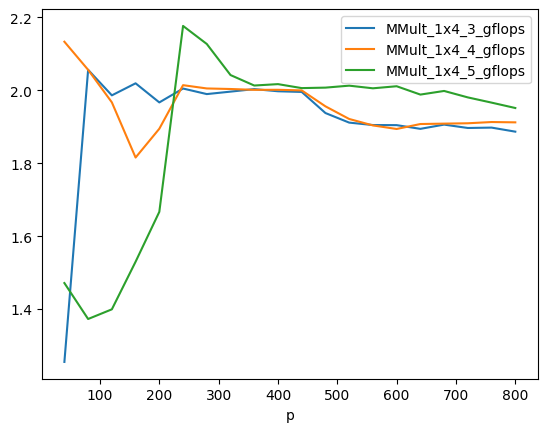

In [9]:
# import result and plot
data = load_data([f'{root_path}/data/MMult_1x4_3.csv', f'{root_path}/data/MMult_1x4_4.csv', f'{root_path}/data/MMult_1x4_5.csv'])
data.plot()

### Result

As we expected, when we fuse 4 inner product into 1 for-loop, we will gain performance. in fact, it is blocking and gain performance due to SIMD
MMult_1x4_5 has performance gain when matrix size bigger than 450

## Optimization 6

We accumulate the elements of C in registers and use a register for elements of A. Using register will also give the performance gain.

* The element of Matrix C will be defined as register variable. in one AddDot, the variable will be reused K times
* The element A(0, p) will be defined as register variable. in one for-loop, this variable will be reused 4 times.
* We could expect the performance gain both on small and big matrix

```
void AddDot1x4( int k, double *a, int lda,  double *b, int ldb, double *c, int ldc )
{
  /* So, this routine computes four elements of C: 

           C( 0, 0 ), C( 0, 1 ), C( 0, 2 ), C( 0, 3 ).  

     Notice that this routine is called with c = C( i, j ) in the
     previous routine, so these are actually the elements 

           C( i, j ), C( i, j+1 ), C( i, j+2 ), C( i, j+3 ) 
	  
     in the original matrix C.

     In this version, we accumulate in registers and put A( 0, p ) in a register */

  int p;
  register double 
    /* hold contributions to
       C( 0, 0 ), C( 0, 1 ), C( 0, 2 ), C( 0, 3 ) */
       c_00_reg,   c_01_reg,   c_02_reg,   c_03_reg,  
    /* holds A( 0, p ) */
       a_0p_reg;
    
  c_00_reg = 0.0; 
  c_01_reg = 0.0; 
  c_02_reg = 0.0; 
  c_03_reg = 0.0;
 
  for ( p=0; p<k; p++ ){
    a_0p_reg = A( 0, p );

    c_00_reg += a_0p_reg * B( p, 0 );     
    c_01_reg += a_0p_reg * B( p, 1 );     
    c_02_reg += a_0p_reg * B( p, 2 );     
    c_03_reg += a_0p_reg * B( p, 3 );     
  }

  C( 0, 0 ) += c_00_reg; 
  C( 0, 1 ) += c_01_reg; 
  C( 0, 2 ) += c_02_reg; 
  C( 0, 3 ) += c_03_reg;
}
```


In [10]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_6 -DOUT=../data/MMult_1x4_6 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

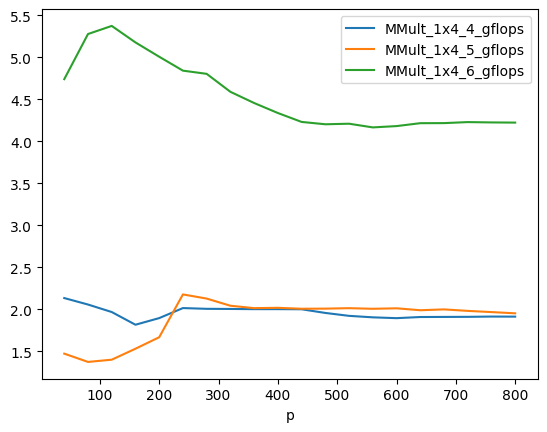

In [11]:
# import result and plot
data = load_data([f'{root_path}/data/MMult_1x4_4.csv', f'{root_path}/data/MMult_1x4_5.csv', f'{root_path}/data/MMult_1x4_6.csv'])
data.plot()

## Optimization 7

We use pointers to address elements in B

```
...
  double 
    /* Point to the current elements in the four columns of B */
    *bp0_pntr, *bp1_pntr, *bp2_pntr, *bp3_pntr; 
    bp0_pntr = &B( 0, 0 );
    bp1_pntr = &B( 0, 1 );
    bp2_pntr = &B( 0, 2 );
    bp3_pntr = &B( 0, 3 );
...

    for ( p=0; p<k; p++ ){
        a_0p_reg = A( 0, p );

        c_00_reg += a_0p_reg * *bp0_pntr++;
        c_01_reg += a_0p_reg * *bp1_pntr++;
        c_02_reg += a_0p_reg * *bp2_pntr++;
        c_03_reg += a_0p_reg * *bp3_pntr++;
      }

...
```

In [12]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_7 -DOUT=../data/MMult_1x4_7 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

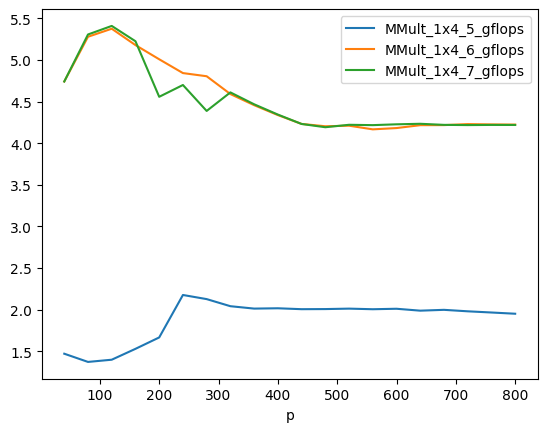

In [13]:
# import result and plot
data = load_data([f'{root_path}/data/MMult_1x4_5.csv', f'{root_path}/data/MMult_1x4_6.csv', f'{root_path}/data/MMult_1x4_7.csv'])
data.plot()

### Result

No performance gain by using pointer to trace element in B

## Optimization 8

We unroll the loop by four (a relatively arbitrary choice of unrolling factor). 
* In inner produt, in one loop, we update C(0,0), C(0,1), C(0,2), C(0,3)
* But each element in C, e.g. C(0,0) we need to do k times update for inner product.
* Here we calucate 4 columns of Matrix A, then we need k/4 loops, each loop we unroll it to do 4 times update


```
    ...
    /* Calculate 4 x 4 update in one loop */
    for ( p=0; p<k; p+=4 ){
        a_0p_reg = A( 0, p );

        c_00_reg += a_0p_reg * *bp0_pntr++;
        c_01_reg += a_0p_reg * *bp1_pntr++;
        c_02_reg += a_0p_reg * *bp2_pntr++;
        c_03_reg += a_0p_reg * *bp3_pntr++;

        a_0p_reg = A( 0, p+1 );

        c_00_reg += a_0p_reg * *bp0_pntr++;
        c_01_reg += a_0p_reg * *bp1_pntr++;
        c_02_reg += a_0p_reg * *bp2_pntr++;
        c_03_reg += a_0p_reg * *bp3_pntr++;

        a_0p_reg = A( 0, p+2 );
    
        c_00_reg += a_0p_reg * *bp0_pntr++;
        c_01_reg += a_0p_reg * *bp1_pntr++;
        c_02_reg += a_0p_reg * *bp2_pntr++;
        c_03_reg += a_0p_reg * *bp3_pntr++;

        a_0p_reg = A( 0, p+3 );

        c_00_reg += a_0p_reg * *bp0_pntr++;
        c_01_reg += a_0p_reg * *bp1_pntr++;
        c_02_reg += a_0p_reg * *bp2_pntr++;
        c_03_reg += a_0p_reg * *bp3_pntr++;
    }
```




In [14]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_8 -DOUT=../data/MMult_1x4_8 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

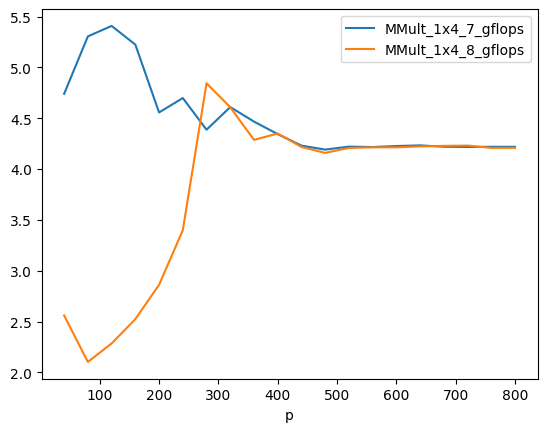

In [15]:
# import result and plot
data = load_data([f'{root_path}/data/MMult_1x4_7.csv', f'{root_path}/data/MMult_1x4_8.csv'])
data.plot()

### Result

No performance gain. 

In [18]:
# build and run the test
! cd $ROOT_PATH/build && cmake ../src -DNEW=MMult_1x4_8 -DOUT=../data/MMult_1x4_8 && make clean &&  make && make test

-- Configuring done
-- Generating done
-- Build files have been written to: /root/build
make -f CMakeFiles/Makefile2 clean
make[1]: Entering directory '/root/build'
make -f CMakeFiles/test_MMult.x.dir/build.make CMakeFiles/test_MMult.x.dir/clean
make[2]: Entering directory '/root/build'
/usr/bin/cmake -P CMakeFiles/test_MMult.x.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeFiles/utils.dir/clean
make[2]: Entering directory '/root/build'
cd /root/build/utils && /usr/bin/cmake -P CMakeFiles/utils.dir/cmake_clean.cmake
make[2]: Leaving directory '/root/build'
make[1]: Leaving directory '/root/build'
/usr/bin/cmake -S/root/src -B/root/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /root/build/CMakeFiles /root/build/CMakeFiles/progress.marks
make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/root/build'
make -f utils/CMakeFiles/utils.dir/build.make utils/CMakeF

<Axes: xlabel='p'>

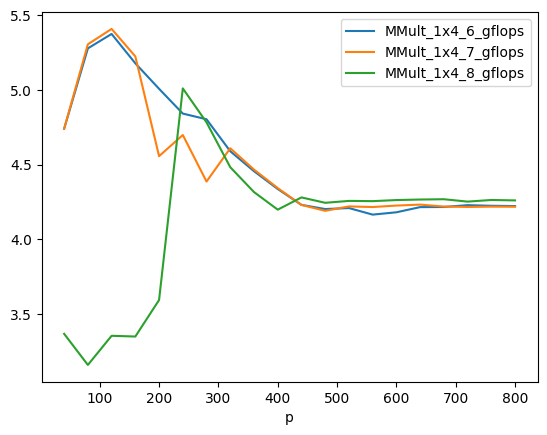

In [19]:
# import result and plot
data = load_data([f'{root_path}/data/MMult_1x4_6.csv', f'{root_path}/data/MMult_1x4_7.csv', f'{root_path}/data/MMult_1x4_8.csv'])
data.plot()